In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

preprocessed = pd.read_csv("data/preprocessed.csv")
cluster_features = pd.read_csv("data/cluster_label_features.csv")
cluster_features.rename(columns={"Unnamed: 0": "original_index"}, inplace=True)

cluster_features = cluster_features[["original_index", "cluster", "opr_mean_pct_diff"]].copy()

preprocessed = preprocessed.merge(cluster_features, right_on="original_index", left_index=True)
preprocessed.drop(columns=["original_index"], inplace=True)


## Clean nulls

In [2]:
# use mean imputation to cover nulls
preprocessed["gross_perforated_length"] = preprocessed["gross_perforated_length"].fillna(preprocessed["gross_perforated_length"].mean())
preprocessed["total_proppant"] = preprocessed["total_proppant"].fillna(preprocessed["total_proppant"].mean())
preprocessed["total_fluid"] = preprocessed["total_fluid"].fillna(preprocessed["total_fluid"].mean())
preprocessed["bin_lateral_length"] = preprocessed["bin_lateral_length"].fillna(preprocessed["bin_lateral_length"].mean())
preprocessed["true_vertical_depth"] = preprocessed["true_vertical_depth"].fillna(preprocessed["true_vertical_depth"].mean())
# preprocessed["ffs_frac_type"] = preprocessed["ffs_frac_type"].fillna(preprocessed["true_vertical_depth"].mean())

# Encode categorical variables

**ffs_fract_type**

In [3]:
preprocessed.ffs_frac_type.value_counts(dropna=False, normalize=True)

ffs_frac_type
Slickwater Only                0.334978
Slickwater Crosslink Hybrid    0.297587
Slickwater Linear Hybrid       0.215018
Undefined                      0.067458
Crosslink Only                 0.057898
NaN                            0.022897
Linear Only                    0.004163
Name: proportion, dtype: float64

In [4]:
preprocessed.ffs_frac_type = preprocessed.ffs_frac_type.fillna("Undefined").map({
    "Slickwater Crosslink Hybrid": "sch",
    "Slickwater Only": "so",
    "8810.144334222554": "number",
    "Slickwater Linear Hybrid": "slh",
    "Undefined": "undefined",
    "Crosslink Only": "co",
    "Linear Only": "lo",
})
preprocessed.ffs_frac_type.value_counts(dropna=False)

ffs_frac_type
so           4345
sch          3860
slh          2789
undefined    1172
co            751
lo             54
Name: count, dtype: int64

## Get dummies

In [5]:
# OHE encode categorical variables
ohe_cols = ["ffs_frac_type",
"relative_well_position",
"batch_frac_classification",
"well_family_relationship"]

for col in ohe_cols:
    preprocessed = pd.concat([preprocessed, pd.get_dummies(preprocessed[col], prefix=col)], axis=1)
    preprocessed.drop(columns=[col], inplace=True)

preprocessed.shape

(12971, 31)

# Randomized Search CV with XGBoost

In [6]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [7]:
preprocessed.drop(columns=["number_of_lateral_stages"], inplace=True)

In [10]:
TARGET_COL = "OilPeakRate"
SEED = 1234

X = preprocessed.drop(columns=[TARGET_COL] + ["cluster"])
y = preprocessed[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Vanilla model

In [14]:
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED)

params = {
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "n_estimators": [200, 300, 500, 800],
    "reg_alpha": [0.01, 0.1, 1, 25, 100],
}

search = RandomizedSearchCV(model,
                        param_distributions=params,
                        n_iter=50,
                        scoring="neg_mean_squared_error",
                        n_jobs=-1, cv=5, 
                        verbose=0, random_state=SEED)

search.fit(X_train, y_train)

y_pred = search.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

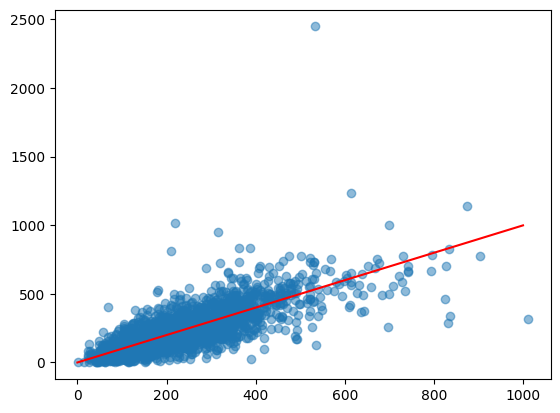

In [ ]:
plt.scatter(
    y_pred,
    y_test,
    alpha=0.5
)

plt.plot(np.arange(0, 1000), np.arange(0, 1000), color="red")   

In [13]:
preprocessed.OilPeakRate.describe()

count    12971.000000
mean       229.236910
std        152.411143
min          0.369048
25%        122.245654
50%        202.594873
75%        304.238142
max       2855.469490
Name: OilPeakRate, dtype: float64